In [5]:
### import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [6]:
import os
path = os.getcwd()
os.chdir(path)

In [9]:
df = pd.read_excel('dfhotels_merged.xlsx')
df.head()

,Hôtels,Note moyenne,Nombre de commentaires,Prix,Arrondissement,Etoiles,perso,equip,prop,conf,rap_qp,situ,wifi
0,Vice Versa,7.9,573,126,15,4,8.1,8.7,8.3,8.1,7.9,7.5,8.8
1,The ReMIX Hotel,8.4,1116,99,19,4,7.8,8.8,8.8,8.8,8.4,8.3,8.3
2,TRIBE Paris Batignolles,9.1,176,130,17,5,8.8,9.6,9.4,9.4,9.2,8.8,9.0
3,Hotel Aida Marais,7.9,1046,141,10,3,8.6,8.7,8.3,7.9,8.1,7.7,7.9
4,Hôtel Hor Les Lumières,8.6,972,117,11,4,9.4,8.8,9.0,8.3,8.5,8.5,8.5


In [10]:
df = df.rename(columns={'Nombre de commentaires':'Nb_comms', 'Note moyenne':'Note_moy'})
df.head()

,Hôtels,Note_moy,Nb_comms,Prix,Arrondissement,Etoiles,perso,equip,prop,conf,rap_qp,situ,wifi
0,Vice Versa,7.9,573,126,15,4,8.1,8.7,8.3,8.1,7.9,7.5,8.8
1,The ReMIX Hotel,8.4,1116,99,19,4,7.8,8.8,8.8,8.8,8.4,8.3,8.3
2,TRIBE Paris Batignolles,9.1,176,130,17,5,8.8,9.6,9.4,9.4,9.2,8.8,9.0
3,Hotel Aida Marais,7.9,1046,141,10,3,8.6,8.7,8.3,7.9,8.1,7.7,7.9
4,Hôtel Hor Les Lumières,8.6,972,117,11,4,9.4,8.8,9.0,8.3,8.5,8.5,8.5


# Analyse descriptive des données#

Repartition des selon les arrondissements

In [ ]:
nbr_hotel = df[['Arrondissement','Hôtels']].groupby('Arrondissement').count().sort_values(by='Hôtels', ascending=False)
nbr_hotel.reset_index(0, inplace=True)
nbr_hotel.rename(columns={'Hôtels':'Nb_Hôtels'}, inplace=True)
nbr_hotel.head()

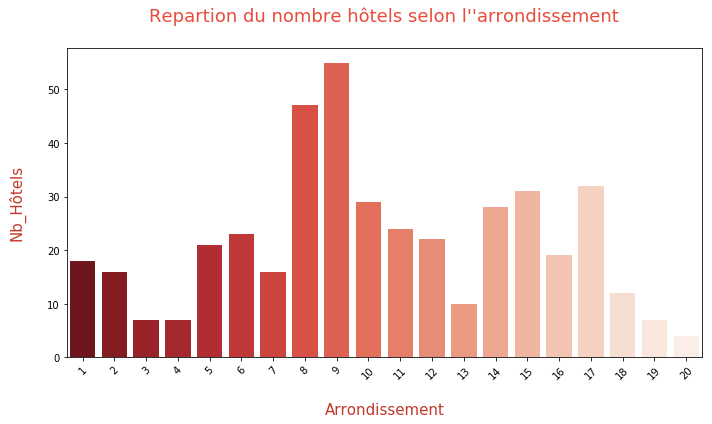

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(x=nbr_hotel['Arrondissement'], y=nbr_hotel['Nb_Hôtels'], palette="Reds_r")
plt.xlabel('\nArrondissement', fontsize=15, color='#c0392b')
plt.ylabel("Nb_Hôtels\n", fontsize=15, color='#c0392b')
plt.title("Repartion du nombre hôtels selon l''arrondissement\n", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

Une disparité de la repartition du nombre d'hôtels selon les arrrondissement. les arrondissemnts 8 et 9 enregistrent les nombre le plus élévées d'hôtels avec plus de de 45 hôtels. 

#Analyse du nombre d'étoiles des hôtels.

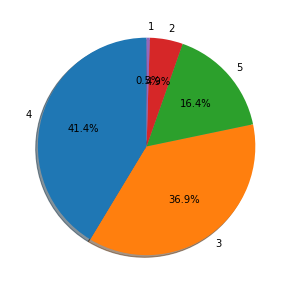

In [29]:
nbr_Etoil= df["Etoiles"].value_counts()
plt.rcParams["figure.figsize"]=[5,5]
plt.pie(nbr_Etoil.values, labels=nbr_Etoil.index, autopct='%1.1f%%',shadow=True, startangle=90)
plt.draw()


Les hôtels 4 étoiles et 3 étoiles sont en surnombre avec une proportion respectives de 41,4 % et 36,9%. 

In [ ]:
nbr_hotel = df[['Arrondissement','Hôtels']].groupby('Arrondissement').count().sort_values(by='Hôtels', ascending=False)
nbr_hotel.reset_index(0, inplace=True)
nbr_hotel.rename(columns={'Hôtels':'Nb_Hôtels'}, inplace=True)
nbr_hotel.head()

In [18]:
Arr_Etoils = df.groupby(['Arrondissement','Etoiles']).size



In [25]:
df["Prix"].describe()

count    428.000000
mean     163.754673
std       61.107753
min       72.000000
25%      119.750000
50%      149.500000
75%      204.250000
max      523.000000
Name: Prix, dtype: float64

# ANALYSE DE LA DISPERSION DES PRIX DES HOTELS#
Pour cela, nous allon faire la boite à moustaches.

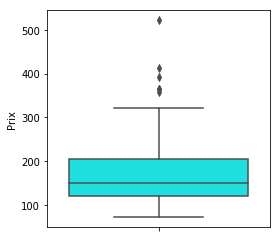

In [44]:
# code permettant de faire le box-polt
sns.boxplot(data = df
            ,y = 'Prix'
            ,color = 'cyan'
            )
plt.rcParams["figure.figsize"]=[2,2]

En observant le graphique ci-dessus. nous poiuvons voir que une distribution du prix des hôtels n''est pas homogène. ( cela s'obssrve par le faite que la médinae n'est pas centé dans la boite). En clair nus pouvons dire nouss avons plus de prix supérieur à la médiane que de prix inférieur. Par la suite nous faisons une representation en fonction des étoiles pour voir dispersion du prix selon en fonction des étoiles.

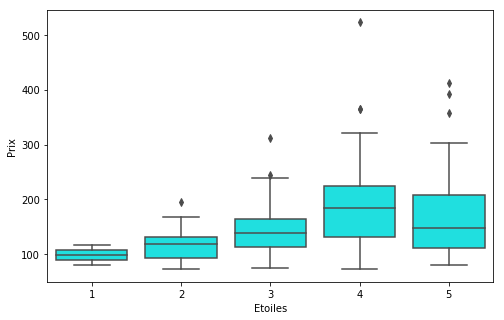

In [60]:
# code pour le box-plot en fonction des étoiles.
sns.boxplot(data = df
            ,y= 'Prix'
            ,x='Etoiles'
            ,color = 'cyan'
            )
plt.rcParams["figure.figsize"]=[2,5]

Par ces graphes nous pouvons dire que la dispersion du prix varie en fonction de l'etoile.Pour les hôtels de 1 et 3 étoiles respectivement ont des prix assez homogène. Pour les autres hôtels, nous observons une distribution assez inégalitaires.
 

# Prix moyens selon les arrondissemnts#

In [16]:
Arr_prix= df[['Arrondissement','Prix']].groupby('Arrondissement').mean().sort_values(by='Prix', ascending= False)
Arr_prix.reset_index(0, inplace=True)
Arr_prix.rename(columns={'Prix':'Prix_Moyen'}, inplace=True)
Arr_prix.head(10)

,Arrondissement,Prix_Moyen
0,1,226.666667
1,2,209.625000
2,7,200.875000
3,6,189.739130
4,4,189.571429
5,8,189.000000
6,16,184.789474
7,9,167.800000
8,5,159.380952
9,17,159.062500


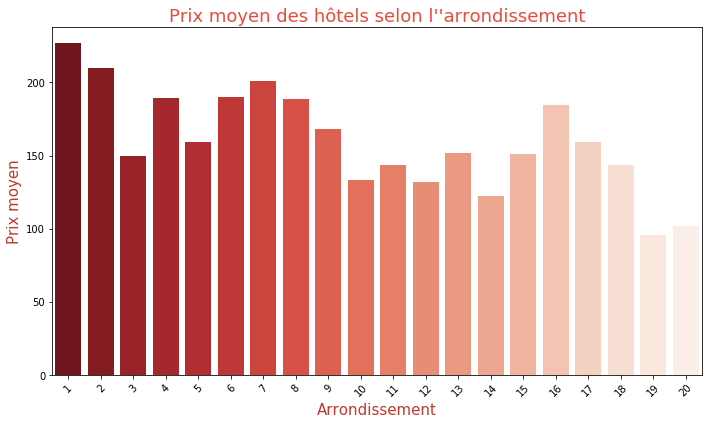

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(x=Arr_prix['Arrondissement'], y=Arr_prix['Prix_Moyen'], palette="Reds_r")
plt.xlabel('Arrondissement', fontsize=15, color='#c0392b')
plt.ylabel("Prix moyen", fontsize=15, color='#c0392b')
plt.title("Prix moyen des hôtels selon l''arrondissement", fontsize=18, color='#e74c3c')
plt.xticks(rotation= 45)
plt.tight_layout()

Par observation du graphique, on remarque que les prix moyens des chambre varie selon l'arrondissemnent. les prix moyens les plus élévés sont observés dans les arrondissments (1,27,16) qui apparaissent comme des arrondissement les plus riche de parisparis selon "(https://www.journaldunet.com/economie/magazine/1097263-les-riches-a-paris-arrondissement-par-arrondissement/1097285-classement)". Cela nous donnons des presomptions sur le faites les prix des chambres pourraient être plus élévé dans les zones riche de paris (nous testerons cette assertion dans la partie modélisation qui suivra)

# Analyse des notes des caractéristiques des chambres. #

# La moyenne générale#

In [11]:
# code pour les nottes moyennes 
df[['Note_moy']].describe()

,Note_moy
count,428.000000
mean,8.257243
std,0.500322
min,6.800000
25%,7.900000
50%,8.300000
75%,8.600000
max,9.600000


L''avis des utilisateurs des hôtels ont portés sur les equipements des chambres, le wifi, la propriété et d'autre caractéristiques. dans l'ensemble les notes moyennes vont de 6,8 à 9,6 sur total de 10 avec une note moyenne de 8.25 par hôtels. 

# Analyse de la notes des autres commodités du logement#

In [65]:
df[['perso','equip','prop','conf','rap_qp','situ','wifi']].describe()

,perso,equip,prop,conf,rap_qp,situ,wifi
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.00000
mean,8.895093,8.958178,8.594159,8.250234,8.229439,7.950234,8.34486
std,0.500631,0.511876,0.549122,0.608353,0.546115,0.566327,0.63890
min,6.400000,6.300000,6.700000,6.500000,6.700000,6.200000,6.10000
25%,8.600000,8.700000,8.300000,7.800000,7.900000,7.600000,7.97500
50%,9.000000,9.000000,8.650000,8.300000,8.300000,8.000000,8.40000
75%,9.300000,9.300000,9.000000,8.700000,8.600000,8.300000,8.80000
max,9.900000,9.800000,9.700000,9.600000,9.400000,9.500000,10.00000


Nous signalons que ces notes attribuées exprimment la satisfaction des usagers de chambre d'hôtels selon une échelle de satisfaction sur 10. selon l’échelle de Likert "https://www.appvizer.fr/magazine/marketing/sondages-et-questionnaires/comment-choisir-echelle-d-attitude-questionnaire-de-satisfaction#id3" :
🗸9-10 Très satisfait
🗸7-8 Satisfait
🗸 5-6 Ni satisfait, ni insatisfait
🗸 2-4Peu satisfait
🗸0-1 Pas du tout satisfait.
Le tableau ci-ddessus montre que 75% des hotels ont une moyenes satisfaisante en ce qui concerne l'ensemble des commodités (par observation du premier quartile). on note des plus que les usagers sont majorité tès satisfaits par le service du personel et d'équipement des chambres ( la moitié des hôtels ont obtenu une note d'au moins 9 pour ces deux caractéristiques. 

# Création d'une variable binaire sur la "richesse" d'un quartier

Pour faciliter l'analyse des résultats de notre régression, on décide de nous servir du numéro d'arrondissement pour connaître quelques caractéristiques supplémentaires de l'emplacement des hôtels. On voudrait notamment savoir si l'arrondissement dans lequel est situé un hôtel est réputé "riche" ou "pauvre". 

Pour cela, on se fie à l'indicateur du nombre d'imposés à l'ISF par arrondissement en 2010 donné par la Direction Générale des Finances Publiques (https://www.journaldunet.com/economie/magazine/1097263-les-riches-a-paris-arrondissement-par-arrondissement/1097285-classement). On décide de considérer comme "riche" un arrondissement dans lequel l'impôt moyen est supérieur à 8 000 € (sur l'année).

On crée donc une variable binaire "Riche" valant 1 si l'arrondissement de l'hôtel appartient à la liste des arrondissements réputés "riches" et 0 sinon.

In [5]:
df['Riche'] = [1 if arr in [16,17,7,6,8,4,1] else 0 for arr in df['Arrondissement']]
df.head()

,Hôtels,Note moyenne,Nombre de commentaires,Prix,Arrondissement,Etoiles,perso,equip,prop,conf,rap_qp,situ,wifi,Riche
0,Vice Versa,7.9,573,126,15,4,8.1,8.7,8.3,8.1,7.9,7.5,8.8,0
1,The ReMIX Hotel,8.4,1116,99,19,4,7.8,8.8,8.8,8.8,8.4,8.3,8.3,0
2,TRIBE Paris Batignolles,9.1,176,130,17,5,8.8,9.6,9.4,9.4,9.2,8.8,9.0,1
3,Hotel Aida Marais,7.9,1046,141,10,3,8.6,8.7,8.3,7.9,8.1,7.7,7.9,0
4,Hôtel Hor Les Lumières,8.6,972,117,11,4,9.4,8.8,9.0,8.3,8.5,8.5,8.5,0


On peut également créer une variable "Sécurité" valant 1 si l'arrondissement est réputé pour être sûr et 0 sinon. Pour cela, on décide d'utiliser une enquête du Parisien (https://www.leparisien.fr/info-paris-ile-de-france-oise/bien-vivre-en-ile-de-france-notre-palmares-a-paris-22-09-2017-7278876.php) en indiquant la sécurité comme seul critère de bien-être (on aurait pu en inclure d'autres, mais nous disposons déjà de notes pour la plupart des autres critères). On décide de considérer comme "sûr" un arrondissement dans lequel le score sur le critère "Sécurité" est supérieur à 80/100.

In [27]:
df['Sûr'] = [1 if arr in [4,5,6,7,15,16,1,2,3,8,12] else 0 for arr in df['Arrondissement']]
df.head()

,Hôtels,Note_moy,Nb_comms,Prix,Arrondissement,Etoiles,perso,equip,prop,conf,rap_qp,situ,wifi,Riche,Sûr
0,Vice Versa,7.9,573,126,15,4,8.1,8.7,8.3,8.1,7.9,7.5,8.8,0,1
1,The ReMIX Hotel,8.4,1116,99,19,4,7.8,8.8,8.8,8.8,8.4,8.3,8.3,0,0
2,TRIBE Paris Batignolles,9.1,176,130,17,5,8.8,9.6,9.4,9.4,9.2,8.8,9.0,1,0
3,Hotel Aida Marais,7.9,1046,141,10,3,8.6,8.7,8.3,7.9,8.1,7.7,7.9,0,0
4,Hôtel Hor Les Lumières,8.6,972,117,11,4,9.4,8.8,9.0,8.3,8.5,8.5,8.5,0,0


# Graphiques de "diagnostic"

Avant de lancer un modèle de régression linéaire, il paraît judicieux de regarder sur des graphiques les relations entre notre variable d'intérêt (les prix) et nos variables explicatives. Par exemple, si l'on remarque une relation quadratique, on préfèrera mettre notre variable explicative au carré dans le modèle de régression. De plus, nos graphiques nous permettront de voir s'il est judicieux de supposer l'homoscédasticité du modèle ou non.

Tout d'abord, il faut noter que la note moyenne, par définition, s'écrit comme combinaison linéaire des autres notes. Cela implique qu'on ne peut pas laisser la note moyenne parmi nos variables explicatives pour notre régression. On décide donc de l'enlever de notre liste de variables à conserver.

In [74]:
df_agarder = df[['Prix', 'Nb_comms', 'Etoiles', 'Note_moy', 'perso', 'equip', 'prop', 'conf', 'rap_qp', 'situ', 'wifi', 'Riche', 'Sûr']]
df_agarder.head()

,Prix,Nb_comms,Etoiles,Note_moy,perso,equip,prop,conf,rap_qp,situ,wifi,Riche,Sûr
0,126,573,4,7.9,8.1,8.7,8.3,8.1,7.9,7.5,8.8,0,1
1,99,1116,4,8.4,7.8,8.8,8.8,8.8,8.4,8.3,8.3,0,0
2,130,176,5,9.1,8.8,9.6,9.4,9.4,9.2,8.8,9.0,1,0
3,141,1046,3,7.9,8.6,8.7,8.3,7.9,8.1,7.7,7.9,0,0
4,117,972,4,8.6,9.4,8.8,9.0,8.3,8.5,8.5,8.5,0,0


<AxesSubplot:>

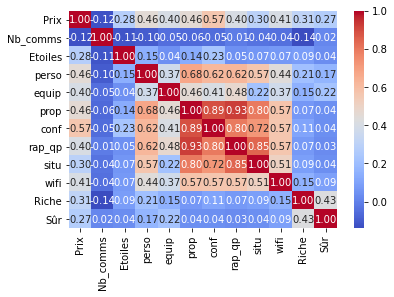

In [29]:
sns.heatmap(df_agarder.corr(), cmap='coolwarm', annot=True, fmt=".2f")

Ce graphique nous montre qu'il y a peu de corrélation entre les variables explicatives (carrés bleus), sauf entre les notes (carrés oranges). À ce niveau-là, on pourrait se demander s'il n'est pas préférable de ne conserver que la note moyenne pour faire notre régression. On décide pour le moment de conserver nos variables explicatives.

In [60]:
def plot_columns(col,df):
    for i, var_exp in enumerate(df.columns):
        if var_exp != col:
            plt.figure(i)
            sns.regplot(x=var_exp, y=col, data=df)

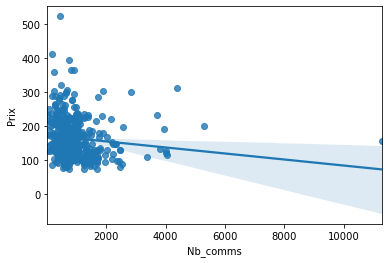

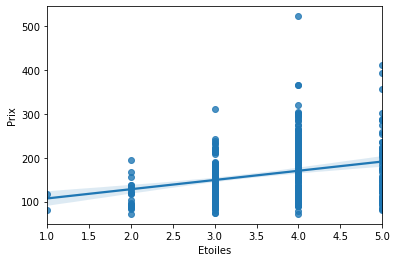

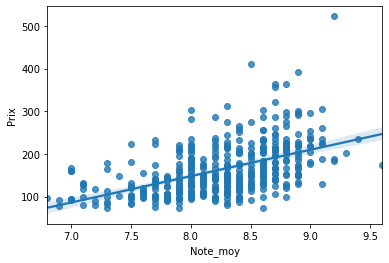

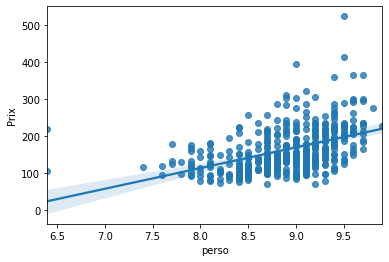

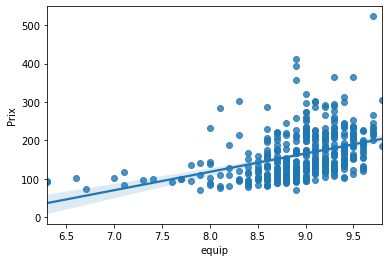

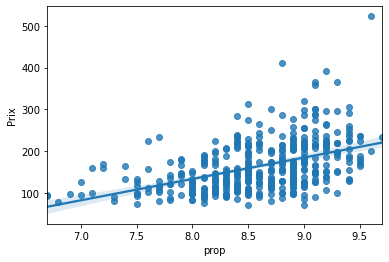

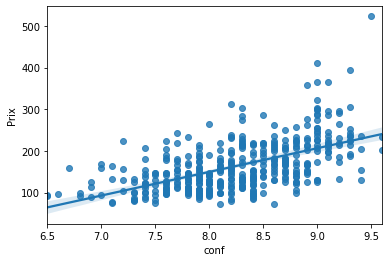

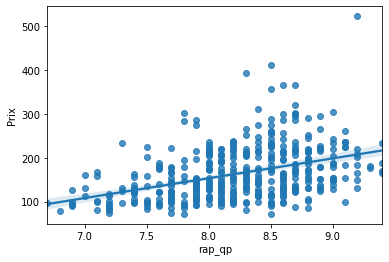

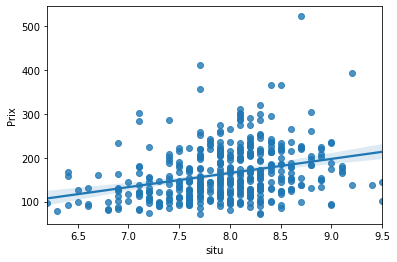

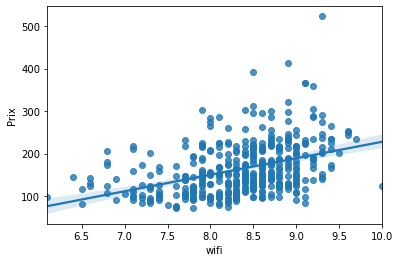

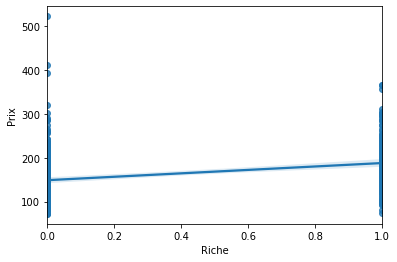

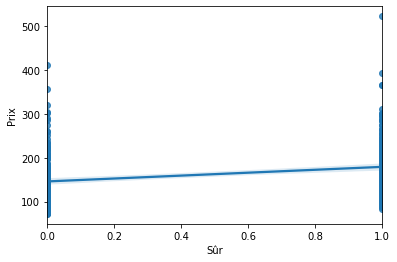

In [75]:
plot_columns('Prix', df_agarder)

Ces graphiques nous montrent que :

- Il n'y a pas de relation claire entre le nombre de commentaires et le prix de réservation. On aurait pu penser que le nombre de commentaires était un indicateur de la popularité des hôtels, et donc aurait pu influencer positivement le prix de vente, mais ce n'est finalement pas le cas.

- Chacune des notes a une relation similaire avec les prix. Ce résultat confirme que les notes selon différents critères sont corrélées, et nous encourage à ne garder que les notes moyennes. De plus, cette relation est hétéroscédastique : la dispersion des points autour des droites de régression n'est pas constante.

- La richesse et la sûreté de l'arrondissement semblent pousser légèrement les prix à la hausse.

# Modèles de régression

On essaye maintenant d'ajuster un modèle de régression à partir de ces variables explicatives. Le premier modèle conserve toutes les variables explicatives exploitables.

### Modèle 1 : inclusion de toutes les variables explicatives

In [65]:
mod = smf.ols(formula = 'Prix ~ Nb_comms + Etoiles + perso + equip + prop + conf + rap_qp + situ + wifi + Riche + Sûr', data=df_agarder)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     35.94
Date:                Sun, 19 Dec 2021   Prob (F-statistic):           1.00e-53
Time:                        12:15:29   Log-Likelihood:                -2224.1
No. Observations:                 428   AIC:                             4472.
Df Residuals:                     416   BIC:                             4521.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -406.7532     50.470     -8.059      0.000    -505.962    -307.544
Nb_comms      -0.0046      0.003     -1.787      0.075      -0.010       0.000
Etoiles        9.4194      2.796      3.369      0.001       3.923      14.915
perso         17.3163      6.059      2.858      0.004       5.406      29.226
equip         11.8582      5.494      2.158      0.031       1.059      22.658
prop         -35.9621     14.387     -2.500      0.013     -64.242      -7.683
conf          64.9413      8.248      7.874      0.000      48.728      81.154
rap_qp        20.0579     13.170      1.523      0.129      -5.831      45.946
situ         -26.4242      7.999     -3.303      0.001     -42.148     -10.700
wifi           9.8591      4.277      2.305      0.022       1.452      18.266
Riche         16.3247      5.069      3.221      0.001       6.361      26.288
Sûr           18.2749      4.921      3.714      0.000       8.602      27.947
==============================================================================
Omnibus:                      136.431   Durbin-Watson:                   1.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              576.529
Skew:                           1.351   Prob(JB):                    6.43e-126
Kurtosis:                       8.003   Cond. No.                     2.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

On peut tout d'abord remarquer que nos variables explicatives expliquent 48% des variations des prix (c'est le $R^2$). Il semble donc y avoir d'autres caractéristiques des hôtels, absentes de notre modèle, qui auraient pu participer à la détermination des prix.

Ce modèle semble mal spécifié : en effet, certaines notes (propreté, endroit) semblent avoir une corrélation négative avec le prix. On décide donc de ne garder dans les notes que celles qui ont le plus de chances d'influencer le prix de réservation : les notes relatives à l'équipement et au personnel. De plus, on ne peut pas dire que le nombre de commentaires et la note de rapport qualité/prix aient un impact significatif sur le prix au niveau de risque (de première espèce) 5%. On décide donc d'exclure ces variables de notre prochain modèle.

### Modèle 2 : suppression des variables explicatives non-significatives

In [224]:
smf.ols(formula = 'Prix ~ Etoiles + Note_moy + Riche + Sûr + perso + equip + wifi', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     40.48
Date:                Sun, 19 Dec 2021   Prob (F-statistic):           1.95e-43
Time:                        23:22:07   Log-Likelihood:                -2256.7
No. Observations:                 428   AIC:                             4529.
Df Residuals:                     420   BIC:                             4562.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -491.9816     51.227     -9.604      0.000    -592.676    -391.288
Etoiles       14.8343      2.862      5.183      0.000       9.209      20.460
Note_moy      26.6865      8.216      3.248      0.001      10.536      42.837
Riche         18.8347      5.336      3.530      0.000       8.347      29.322
Sûr           14.9418      5.225      2.860      0.004       4.672      25.212
perso         12.2427      7.116      1.721      0.086      -1.744      26.230
equip         16.6318      5.441      3.057      0.002       5.937      27.327
wifi          12.9194      4.448      2.904      0.004       4.175      21.663
==============================================================================
Omnibus:                      145.114   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              612.559
Skew:                           1.447   Prob(JB):                    9.65e-134
Kurtosis:                       8.096   Cond. No.                         395.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ce modèle produit des résultats plus cohérents puisque chaque indicateur a une influence positive sur les prix de réservation. Toutefois, il est légitime de se demander si on doit laisser les variables 'Etoiles' et celles relatives aux notes telles quelles. En effet :

- d'une part, la variable 'Etoiles' prend des valeurs entières comprises entre 0 et 5
- d'autre part, les variables de notes prennent des valeurs comprises entre 0 et 10 (et même entre 6 et 10 dans notre jeu de données)

On peut essayer de transformer ces variables en variables catégorielles. Autrement dit, à partir d'une colonne associée à une variable explicative prenant $k$ valeurs possibles, on peut obtenir $k-1$ colonnes binaires avec des 1 si la variable explicative prend la valeur correspondante et 0 sinon. Il est nécessaire de prendre $k-1$ colonnes et non $k$, car sinon leur somme formera une variable constante égale à 1, et on aura alors une relation linéaire entre toutes ces colonnes, rendant la régression linéaire impossible.

Ici, on peut par exemple transformer la variable 'Etoiles' en 4 variables catégorielles :

- 1 ou 2 étoiles
- 3 étoiles
- 4 étoiles
- 5 étoiles

et ne pas garder la variable '3 étoiles', qui est le niveau de qualité médian de notre jeu de données. Cela nous permettra de voir l'évolution des prix lorsque l'on a affaire à des hôtels de qualité plus basse (- de 3 étoiles) ou élevée (+ de 3 étoiles). On regroupe les hôtels à 1 ou 2 étoiles, car on n'a pas assez d'hôtels à 1 étoile dans notre jeu de données, ce qui aurait pu conduire à des résultats imprécis.

De même, pour chaque critère, on regroupe :
- les notes suffisamment élevées pour dire que l'hôtel a cherché à se démarquer de la concurrence sur ce critère
- les notes suffisamment basses pour dire que l'hôtel s'est moins focalisé sur ce critère que les autres

Ces notes sont choisies de sorte qu'il y ait suffisamment d'hôtels (au moins 25) dans ces deux catégories. Il est donc utile de regarder les valeurs prises par nos variables de notes.

In [112]:
df["Etoiles"].value_counts()

4    177
3    158
5     70
2     21
1      2
Name: Etoiles, dtype: int64

In [156]:
df['cinq_etoiles'] = df['Etoiles']==5
df['quatre_etoiles'] = df['Etoiles']==4
df['moins_de_trois_etoiles'] = df['Etoiles']<3

In [182]:
df["equip"].value_counts().sort_index(ascending=False).head()

9.8     2
9.7    10
9.6    16
9.5    28
9.4    31
Name: equip, dtype: int64

In [139]:
df['equipTB'] = df['equip']>=9.5
df['equipM'] = df['equip']<=8

In [184]:
df["perso"].value_counts().sort_index(ascending=False).head()

9.9     1
9.8     1
9.7    11
9.6    16
9.5    17
Name: perso, dtype: int64

In [185]:
df["perso"].value_counts().sort_index(ascending=True).head()

6.4    2
7.4    1
7.6    2
7.7    3
7.8    2
Name: perso, dtype: int64

In [140]:
df['persoTB'] = df['perso']>=9.5
df['persoM'] = df['perso']<=8

In [186]:
df["prop"].value_counts().sort_index(ascending=False).head()

9.7     1
9.6     2
9.5     8
9.4    16
9.3    13
Name: prop, dtype: int64

In [196]:
df["prop"].value_counts().sort_index(ascending=True).head(10)

6.7    2
6.8    1
6.9    1
7.0    2
7.1    2
7.2    2
7.3    2
7.4    2
7.5    7
7.6    4
Name: prop, dtype: int64

In [197]:
df['propTB'] = df['prop']>=9.3
df['propM'] = df['prop']<=7.6

In [191]:
df["conf"].value_counts().sort_index(ascending=False).head()

9.6     2
9.5     1
9.4     4
9.3    11
9.2     9
Name: conf, dtype: int64

In [200]:
df["conf"].value_counts().sort_index(ascending=True).head(9)

6.5    2
6.6    1
6.7    1
6.8    2
6.9    3
7.0    3
7.1    4
7.2    4
7.3    8
Name: conf, dtype: int64

In [201]:
df['confTB'] = df['conf']>=9.2
df['confM'] = df['conf']<=7.3

In [206]:
df["situ"].value_counts().sort_index(ascending=False).head(6)

9.5    2
9.4    1
9.2    2
9.1    4
9.0    6
8.9    8
Name: situ, dtype: int64

In [209]:
df["situ"].value_counts().sort_index(ascending=True).head(9)

6.2    1
6.3    1
6.4    3
6.5    2
6.6    3
6.7    1
6.8    3
6.9    9
7.0    3
Name: situ, dtype: int64

In [176]:
df['situTB'] = df['situ']>=8.9
df['situM'] = df['situ']<=7

In [213]:
df["wifi"].value_counts().sort_index(ascending=False).head(6)

10.0     1
9.7      1
9.6      3
9.5      1
9.4      7
9.3     11
Name: wifi, dtype: int64

In [214]:
df["wifi"].value_counts().sort_index(ascending=True).head(8)

6.1    1
6.4    1
6.5    2
6.6    3
6.8    5
6.9    2
7.0    1
7.1    8
Name: wifi, dtype: int64

In [215]:
df['wifiTB'] = df['wifi']>=9.3
df['wifiM'] = df['wifi']<=7.1

### Modèle 3 : utilisation de variables catégorielles

In [222]:
smf.ols(formula = 'Prix ~ cinq_etoiles + quatre_etoiles + moins_de_trois_etoiles + Riche + Sûr + persoTB + persoM + equipTB + equipM + situTB + situM + wifiTB + wifiM', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     21.78
Date:                Sun, 19 Dec 2021   Prob (F-statistic):           2.15e-39
Time:                        23:17:54   Log-Likelihood:                -2255.5
No. Observations:                 428   AIC:                             4539.
Df Residuals:                     414   BIC:                             4596.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        125.7121      5.016     25.061      0.000     115.852     135.573
cinq_etoiles[T.True]              23.9042      6.972      3.428      0.001      10.198      37.610
quatre_etoiles[T.True]            35.7811      5.402      6.624      0.000      25.163      46.399
moins_de_trois_etoiles[T.True]    -8.6653     10.866     -0.797      0.426     -30.024      12.694
persoTB[T.True]                   44.1525      8.079      5.465      0.000      28.272      60.033
persoM[T.True]                    -5.8137     10.240     -0.568      0.571     -25.942      14.314
equipTB[T.True]                   24.4054      7.499      3.254      0.001       9.664      39.147
equipM[T.True]                   -33.0244     10.687     -3.090      0.002     -54.031     -12.018
situTB[T.True]                    -0.8108      7.025     -0.115      0.908     -14.620      12.999
situM[T.True]                    -18.2249      6.397     -2.849      0.005     -30.799      -5.651
wifiTB[T.True]                    34.3998     10.367      3.318      0.001      14.021      54.779
wifiM[T.True]                    -14.0755     10.741     -1.310      0.191     -35.190       7.039
Riche                             17.1251      5.382      3.182      0.002       6.546      27.704
Sûr                               19.5059      5.213      3.742      0.000       9.259      29.753
==============================================================================
Omnibus:                      130.054   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              421.250
Skew:                           1.385   Prob(JB):                     3.36e-92
Kurtosis:                       6.994   Cond. No.                         7.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Ce modèle permet d'interpréter le prix des hôtels comme somme d'un prix fixe (interprétable comme le coût pour un couple de dormir une nuit dans une chambre d'hôtel à Paris) et de coûts supplémentaires (ou des baisses de prix) selon les caractéristiques des hôtels. Notons que dans ce modèle, le 'prix fixe' est positif, donc le modèle semble mieux spécifié que les précédents.

Ce modèle appelle plusieurs interprétations :
- Il semble que les hôtels à 5 étoiles coûtent moins cher à la réservation que les hôtels à 4 étoiles, ce que l'on pouvait déjà percevoir sur le graphique de diagnostic (avec le nombre d'étoiles en abscisses et le prix en ordonnées). À première vue, ce résultat n'est pas cohérent, mais en y regardant de plus près, l'intervalle de confiance à 95% de la valeur "exacte" de l'effet marginal est comprise entre 10 et 38 pour les hôtels 5 étoiles, et entre 25 et 46 pour les hôtels 4 étoiles. Il est donc possible que l'effet marginal sur les prix d'un hôtel 5 étoiles soit plus important que pour un hôtel 4 étoiles.
- Au niveau de risque 5%, on ne peut pas dire que le fait qu'un hôtel ait moins de 3 étoiles a un effet significatif sur le prix de réservation de la chambre. Si un tel effet marginal existait, il serait négatif, ce qui semble cohérent, car par rapport à l'ensemble des hôtels de la base de données, les hôtels à moins de 3 étoiles paraissent moins bien côtés.
- Le fait d'avoir un personnel apprécié (très bonne note pour ce critère) conduit à une augmentation du prix assez marquée par rapport au cas où le personnel est moins apprécié (note moyenne ou basse). Une possibilité d'explication est que l'hôtel paie davantage son personnel ou embauche plus pour améliorer sa qualité de service, ce qui se traduit par une augmentation des prix en conséquence.
- Il en est de même pour l'équipement, pour des raisons similaires (l'équipement est payé par l'hôtel, qui répercute ensuite ces coûts sur le prix de réservation).
- Le fait d'être dans un quartier riche ou sûr augmente naturellement le prix de réservation, car ces deux caractéristiques attirent les clients. Inversement, le fait d'être dans un arrondissement pauvre ou réputé pour son insécurité peut rebuter certains clients potentiels.